# CSE488 Project

I want you to pretend you are competing in http://celltrackingchallenge.net/.  Unfortunately, we missed the ISBI2024 deadline but practicing on a realistic challenges is good practice. There may be a 2025 challenge…..


**NOTE:** I am sharing this on colab, but you will likely want to run jupyter locally to do this project.  Colab will kick you out and you will lose your data after a few hours unless you pay them.

# Data and Starter Code

The goal of this project is to successfully segment cell images.

You will use the evaluation programs provided by the challenge creators to evaluate your results.  The cells below will download the testing program.

In [1]:
# Initial cell (automatically executed)
try:
  import imagecodecs   # Needed to open compressed tif files
except:
  %pip install imagecodecs  # Needed to open compressed tif files

import os
from IPython.display import clear_output
clear_output()

In order for data to persist on Google colab, I have this set up to link to your Google Drive account.   
You may instead wish to work locally, which would inolve installing Jupyter instead.  [Instructions are here](https://test-jupyter.readthedocs.io/en/latest/install.html).   

The next cell should only be executed if you are using colab:

In [2]:
# Mount Google Drive (a popup window will show)
try:
  from google.colab import drive
  drive.mount('/content/drive')

  # Create a project folder if it does nto already exist, and SymLink to it.
  BASE_PATH='/content/drive/MyDrive/CSE588/Project'
  !mkdir -p {BASE_PATH}
  !ln -s {BASE_PATH}

except ModuleNotFoundError:
  print("You appear to be running things locally, please set the BASE_PATH accordingly")
  BASE_PATH="./"

Mounted at /content/drive


This project is based on an official comptetition.   
The competition comes with (C++) code to evaluate your cell segmentation results uing the Jaccard index (intersection over union).  
The next cell downloads their code.  

**NOTE**: The cell assumes you are using Linux.

In [3]:
# Download the official evaluation software and uncompress it.
if not os.path.exists(f'{BASE_PATH}/Linux/SEGMeasure'):
  !wget http://public.celltrackingchallenge.net/software/EvaluationSoftware.zip -O {BASE_PATH}/EvaluationSoftware.zip
  !unzip {BASE_PATH}/EvaluationSoftware.zip -d {BASE_PATH}
  clear_output()

# Make SEGMeasure executable
import sys
if sys.platform != 'linux':
  print("You need to put the right version SEGMeasure in your path and make sure it is executable.")
else: # linux
  os.environ['PATH'] = f'{BASE_PATH}/Linux' + os.pathsep + os.environ['PATH']
  !chmod a+x {BASE_PATH}/Linux/SEGMeasure


The input images come with associated ground-truth files.  
The names of the files are important (note the pattern [described here](https://public.celltrackingchallenge.net/documents/Naming%20and%20file%20content%20conventions.pdf))

Essentially:   
 -  The data is a set of videos. The file name starts with the video (e.g. 01)
 -  The labels are either manual "gold" truth  (01_GT)
 -  Or they are the consensus of automatic methods, "silver" truth (01_ST)
 -  The input files have named like `t001.tif` for which is the input at time 1.
 -  The target files for the semantic segmentation task (our chellenge) are named like `SEG/man_seg001.tif`.
 -  Your predictions will be in a folder like `01_RES` with a name like `mask001.tif`.

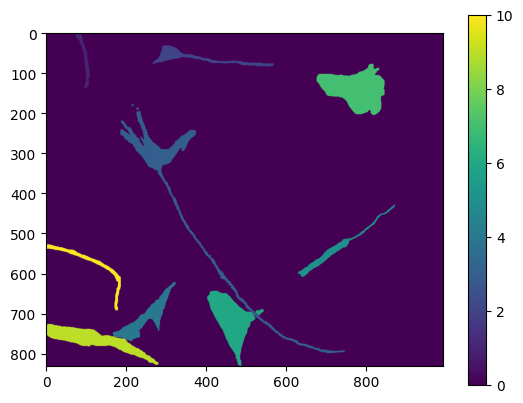

In [4]:
from skimage import io
from matplotlib.pylab import plt

gt = io.imread('Project/testing_dataset/01_GT/SEG/man_seg045.tif')
plt.imshow(gt);
plt.colorbar()

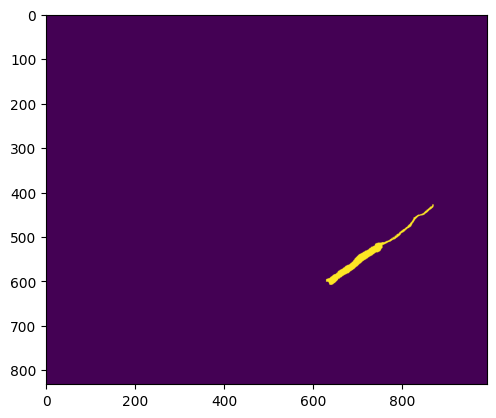

In [5]:
plt.imshow(gt==5)

Your job is to produce a corresponding _results_ file

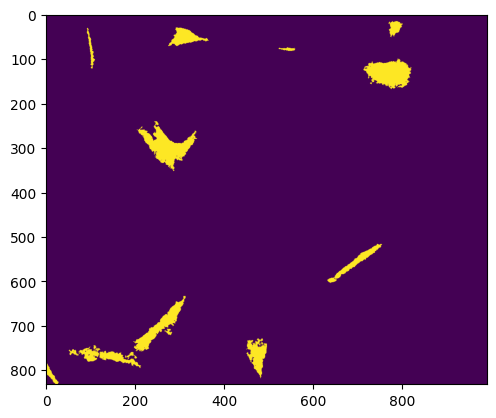

In [6]:
result = io.imread('Project/testing_dataset/01_RES/mask045.tif')
plt.imshow(result >0)

The segmentation accuracy for this contest is based on:
1.   Matching a result with one of the GT objects (overlap > 50%)
2.   Computing the Intersection-over-Union (IoU) of the objects.

The IoU is also called the Jaccard index.  
To help you with debugging things and to make things clear, I have a python version of the evaluation code below:

In [7]:
import numpy as np
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment

def compute_jaccard_index_for_matches(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask = label(seg_mask)
    # Extract properties of labeled regions
    mask_props = regionprops(labeled_mask)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in np.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize an array to hold overlaps with mask objects
        overlaps = []

        for prop in mask_props:
            # Calculate intersection and union with each segmented object
            intersection = np.sum(ref_object & (labeled_mask == prop.label))
            union = np.sum(ref_object | (labeled_mask == prop.label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * np.sum(ref_object):
                jaccard_index = intersection / union
                overlaps.append(jaccard_index)
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[ref_label] =best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = np.mean(list(jaccard_indices.values())) if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices


In [8]:
metrics = compute_jaccard_index_for_matches(gt, result)

# IoU = Jaccard index (different name, same thing)
mIoU,  per_obj_IoUs = metrics
print(f"mIoU={mIoU}")
for object_index in per_obj_IoUs:
  print(f"Best IoU for target object {object_index:>3} is {per_obj_IoUs[object_index]}")

mIoU=0.16249413515519567
Best IoU for target object   1 is 0
Best IoU for target object   2 is 0.4962600690448792
Best IoU for target object   3 is 0
Best IoU for target object   4 is 0.5883534136546185
Best IoU for target object   5 is 0.540327868852459
Best IoU for target object   6 is 0
Best IoU for target object   7 is 0
Best IoU for target object   8 is 0
Best IoU for target object   9 is 0
Best IoU for target object  10 is 0


Your goal is to process an entire test set, and evaluate it using their evaluation program (similar to the python function I included above)

In [9]:
if not os.path.isfile('MySEGMeasure.py'):
  !wget https://gist.github.com/jfemiani/81e5f6dbed8a949306d5a84df8f4e8eb/raw/144973730afaeb28640f3b0d10f7d311df410f3c/MySEGMeasure.py

# Explanation:
#   Put your validation data ST into a folder for the FIRST argument/
#      Filenames begin with man_seg###.tif
#   Put your results in a folder for the SECOND argument.
#      Filenames are mask####.tif
%run MySEGMeasure.py  {BASE_PATH}/testing_dataset/01_GT/SEG {BASE_PATH}/testing_dataset/01_RES

--2025-12-05 00:30:09--  https://gist.github.com/jfemiani/81e5f6dbed8a949306d5a84df8f4e8eb/raw/144973730afaeb28640f3b0d10f7d311df410f3c/MySEGMeasure.py
Resolving gist.github.com (gist.github.com)... 140.82.121.4
Connecting to gist.github.com (gist.github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/jfemiani/81e5f6dbed8a949306d5a84df8f4e8eb/raw/144973730afaeb28640f3b0d10f7d311df410f3c/MySEGMeasure.py [following]
--2025-12-05 00:30:09--  https://gist.githubusercontent.com/jfemiani/81e5f6dbed8a949306d5a84df8f4e8eb/raw/144973730afaeb28640f3b0d10f7d311df410f3c/MySEGMeasure.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3562 (3.5K) [text/plain]
Saving to: ‘My

<Figure size 640x480 with 0 Axes>

## Getting The Fluo-N2DH-GOWT1 Data Set

Several types of cell data are provided at http://celltrackingchallenge.net/2d-datasets/

For now, try to handle the mouse cells...

In [10]:
BASE_PATH

'/content/drive/MyDrive/CSE588/Project'

In [11]:
!mkdir -p {BASE_PATH}/training-datasets
!mkdir -p {BASE_PATH}/test-datasets

# Consider other datasets from http://celltrackingchallenge.net/2d-datasets/

if not os.path.exists('Project/training-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/training-datasets/

if not os.path.exists('Project/test-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/test-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/test-datasets/


Here is an example of one image

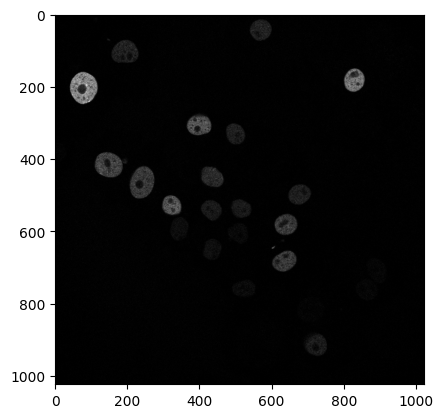

In [12]:
plt.imshow(io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t000.tif'), cmap='gray');

Not every cell was labeled in the GT folder, so you may want to use the ST folder to tune your segmentation method.

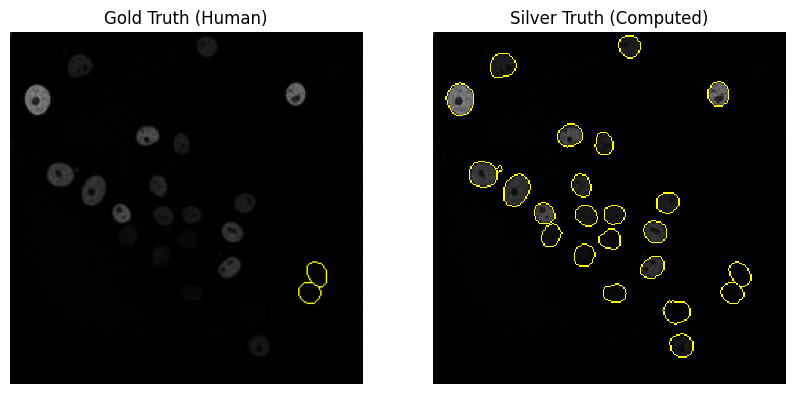

In [13]:
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
import matplotlib.pyplot as plt
import skimage.io as io

plt.figure(figsize=(10,5))

# Shrinking images to make outlines clearere
input_image = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t005.tif')
input_image = resize(input_image, (256, 256))

plt.subplot(121)
gt_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/man_seg005.tif')
gt_segmentation = resize(gt_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, gt_segmentation))
plt.title("Gold Truth (Human)")
plt.axis('off')

plt.subplot(122)
st_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg005.tif')
st_segmentation = resize(st_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, st_segmentation), interpolation='nearest')
plt.title("Silver Truth (Computed)");
plt.axis('off');

# Goal

Your task is to try and classify the pixels in order to segment cells.

To help you out, I have a code snippet for neighborhood-based set of features to use for classifying.


You are to prepare a table comparing several methods of segmenting the cells.
1.  Use a Naive Bayesian classifier [sklearn.naive_bayes.GaussianNB](https://letmegooglethat.com/?q=sklearn+nauive+bayes)
2.  Use logistic regression [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
3.  Use a SVM (play with different kernels - I demoed RBF only)
4.  Use a neural network (on the features) (use sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html))
5.  Use a convnet (on the original image) either of your own design or one of the pytorch models (such as [`FCN_ResNet`](https://colab.research.google.com/drive/1zgnXGmV7EVqAi8XnQc2qvBmDn7ArIrtG?usp=drive_fs#scrollTo=337f8b00-aee6-4072-8540-64b57ad37ba9))

In addition, you can explore ways to preprocess the image (histogram equalization, denoising) or postprocess in order to improve results.



# Approach
Put your code and explanation in this section

What I expect you to do it to generate a "RES" folder for each method, and use SEGMeasure to quantify your results. For example, create folders

mkdir -p {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_NAIVE_BAYES
mkdir -p {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_LOG_REG
...

Then, to evaluate Naive Bayes:

ln -s {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_NAIVE_BAYES {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES
SEGMeasure {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1 01 3

and record the result.

# **Segmentation Code**

In [ ]:
import os
import glob
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from skimage.morphology import dilation, disk, opening, closing, erosion
import pandas as pd
from skimage.exposure import equalize_hist
import pickle

In [ ]:
from skimage.util import view_as_windows

def getImgFeatures(image_dir, window_size):
    image = io.imread(image_dir)
    image = equalize_hist(image)
    # add any sort of preprocessing in the flat features
    height, width = image.shape
    image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
    flat_features = image_features.reshape(height*width, window_size**2)
    return flat_features, image.shape

def getTarget(target_dir):
    target_image = io.imread(target_dir)
    targets = target_image.flatten() > 0
    num_fg = np.sum(targets)
    num_bg = len(targets) - num_fg
    weights = np.where(targets==0, num_fg, num_bg)
    return targets, weights

In [ ]:
from tqdm import trange
training_folder = os.path.join(f"{BASE_PATH}", "training-datasets", "Fluo-N2DH-GOWT1")
image_folders = glob.glob(os.path.join(training_folder, "0[0-9]"))
mask_folders = glob.glob(os.path.join(training_folder, "0[0-9]_ST"))

def getTrainingMatrix(image_folders, mask_folders, sample_size=100, dataset_size=None, window_size=10):
    final_df = pd.DataFrame()
    img_shape = 0
    for i in trange(len(image_folders)):
        img_folder = image_folders[i]
        mask_folder = mask_folders[i]
        img_names = sorted(glob.glob(os.path.join(img_folder, "*.tif")))
        mask_names = sorted(glob.glob(os.path.join(mask_folder, "SEG", "*.tif")))
        if not dataset_size:
            dataset_size = len(img_names)
        for j in range(dataset_size):
            _image_dir = img_names[j]
            _msk_dir = mask_names[j]
            flat_features, img_shape = getImgFeatures(_image_dir, window_size)
            targets, weights = getTarget(_msk_dir)
            temp_df = pd.DataFrame(flat_features)
            temp_df['target'] = targets
            # sample from the retrived dataframe
            sample_df = temp_df.sample(sample_size, weights=weights)
            if len(final_df) == 0:
                final_df = sample_df
            else:
                final_df = pd.concat([final_df, sample_df])
    return final_df, img_shape

training_df, img_shape = getTrainingMatrix(image_folders, mask_folders, sample_size=100, window_size=5, dataset_size=None)

100%|██████████| 2/2 [02:02<00:00, 61.22s/it]


In [ ]:
data = training_df

In [ ]:
X, y = data.values[:,:-1], data.values[:,-1].astype(int)

In [ ]:
X.shape

(18400, 25)

In [ ]:
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes=(100, 50, 25)
activation='tanh'

mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                           activation=activation,
                           max_iter=1000, random_state=42)
mlp.fit(X, y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50, 25),
              max_iter=1000, random_state=42)

In [ ]:
test_image = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/man_seg091.tif')

In [ ]:
test_img_features, shape = getImgFeatures(f'{BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/02/t091.tif', window_size=5)

In [ ]:
mlp_prediction = mlp.predict(test_img_features).reshape(shape)
mlp_probabs = mlp.predict_proba(test_img_features)

In [ ]:
def process01(predictions):
    eroded = erosion(predictions, disk(1))
    # dialated = dilation(eroded, disk(3))
    return eroded
def process02(predictions):
    eroded = erosion(predictions, disk(1))
    dialated = dilation(eroded, disk(1))
    return dialated

In [ ]:
mlp_preprocessed = process02(mlp_prediction)

# **Testing after preprocessing**

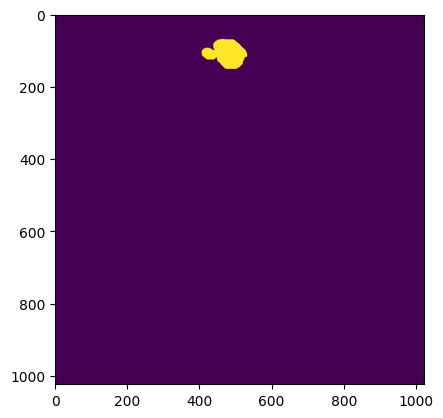

In [ ]:
plt.imshow(test_image)

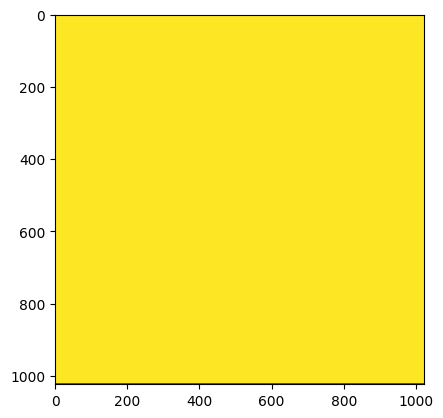

In [ ]:
plt.imshow(mlp_preprocessed)


# **Visualization for Different models**

In [ ]:
jacc_mlp_prep = compute_jaccard_index_for_matches(test_image, mlp_preprocessed)

# **Saving Models**

In [ ]:
import pickle

# Load pickled data from file
def save_model(model, model_name):
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [ ]:
save_model(mlp, "MLP")

In [ ]:
from tqdm import tqdm
def create_test_inferences(model, model_name, resize_shape=(256,256), window_size=5, postprocess=False):
    pdir_name = os.path.join(BASE_PATH, "test-datasets", "Fluo-N2DH-GOWT1")
    tracks = glob.glob(os.path.join(pdir_name, "", "0[0-9]"))
    # print(tracks)
    with tqdm(total=len(tracks)) as pbar:
        for track_number in tracks:
            # print(track_number)
            dir_name = os.path.join(pdir_name, f"{track_number}_{model_name}", "")
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            test_img_names = glob.glob(os.path.join(pdir_name, track_number, "*.tif"))

            # pbar.write(f"Working on {model_name} -- {track_number[-2:]}")
            for test_img_name in test_img_names:
                # print(test_img_name)
                test_img_path = os.path.join(pdir_name, track_number, test_img_name)
                test_img = io.imread(test_img_path)
                test_img_features, shape = getImgFeatures(test_img_path, window_size=window_size)
                predicted = model.predict(test_img_features).reshape(shape).astype(np.uint8)
                if postprocess:
                    if track_number == '01':
                        predicted = process01(predicted)
                    else:
                        predicted = process02(predicted)
                saving_path = os.path.join(dir_name, f"mask{test_img_name[-7:-4]}.tif")
                io.imsave(saving_path, predicted, check_contrast=False)
            pbar.update(1)

In [ ]:
create_test_inferences(mlp, "MLP", window_size=5, postprocess=True)

100%|██████████| 2/2 [02:21<00:00, 70.54s/it]


# **MLP Visual Evaluation**

In [ ]:
img_num = ["000", "045", "091"]
def display_all_viz(images, track, model):
    for image in images:
        displayResults(model, image, track)

In [ ]:
def displayResults(model, img_num, track):
    img = io.imread(f"{BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/{track}/t{img_num}.tif")
    ground_truth = io.imread(f"{BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/{track}_GT_SEG/man_seg{img_num}.tif") > 0
    predicted = io.imread(f"{BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/{track}_{model}/mask{img_num}.tif")
    # predicted = dilation(predicted, disk(5))
    names = {
        'N_BAYES' : "Naive Bayes",
        'SVC_L' : "Support Vector Machine (Linear)",
        'SVC_R' : "Support Vector Machine (RBF)",
        'LOG' : "Logistic Regression",
        'MLP' : "Net(v1)",
        'CNN' : "CNN"
    }
    fig, ax = plt.subplots(1,3, figsize=[20,15])
    ax[0].imshow(img, cmap='gray')
    ax[0].axis("off")
    ax[0].set(title=f"Cell Image (Track_{track} : {img_num})")
    ax[1].imshow(ground_truth, cmap='gray')
    ax[1].axis('off')
    ax[1].set(title='Ground Truth (Silver Truth)')
    ax[2].imshow(predicted, cmap='gray')
    ax[2].axis('off')
    ax[2].set(title=f'Predicted ({names[model]})');

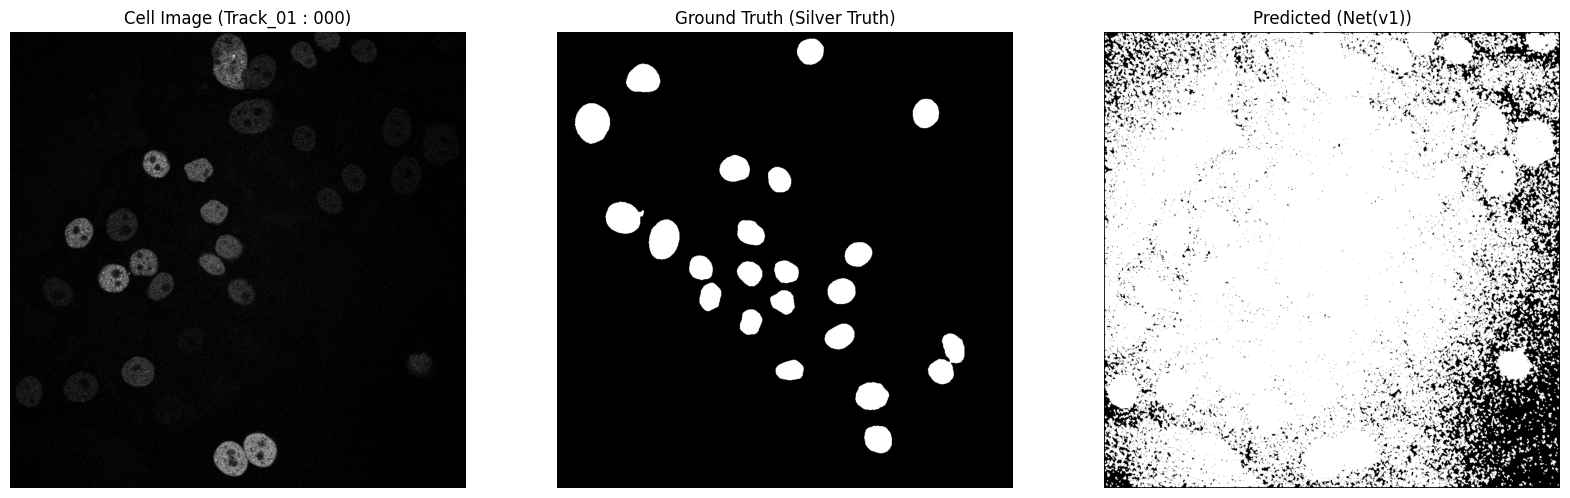

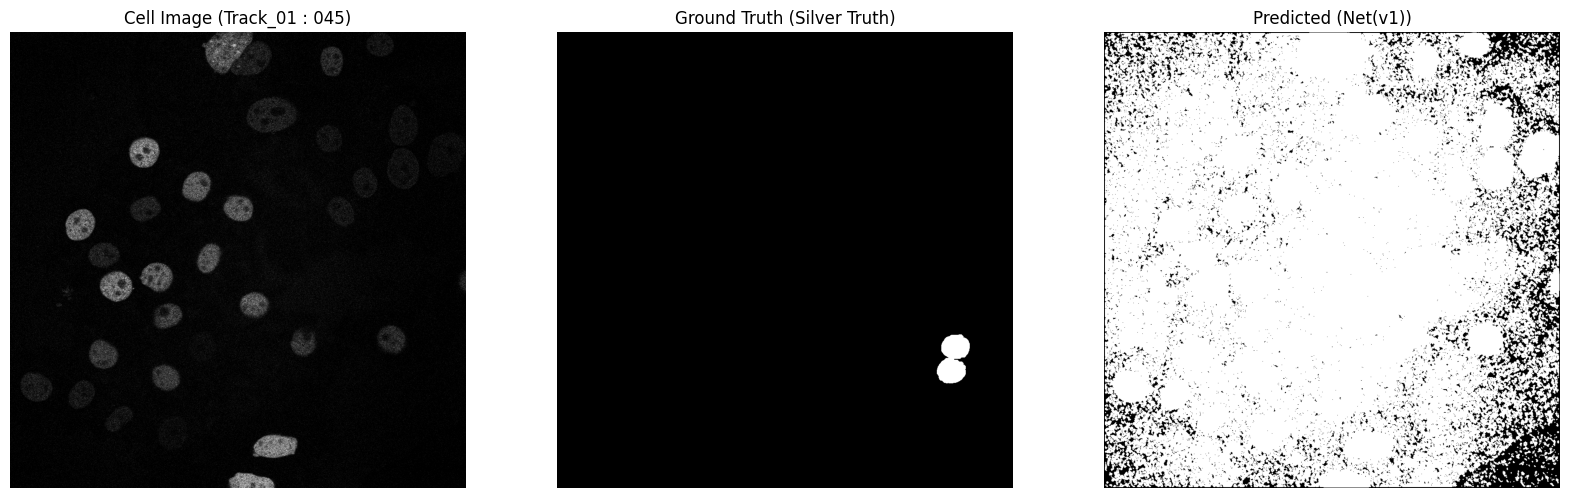

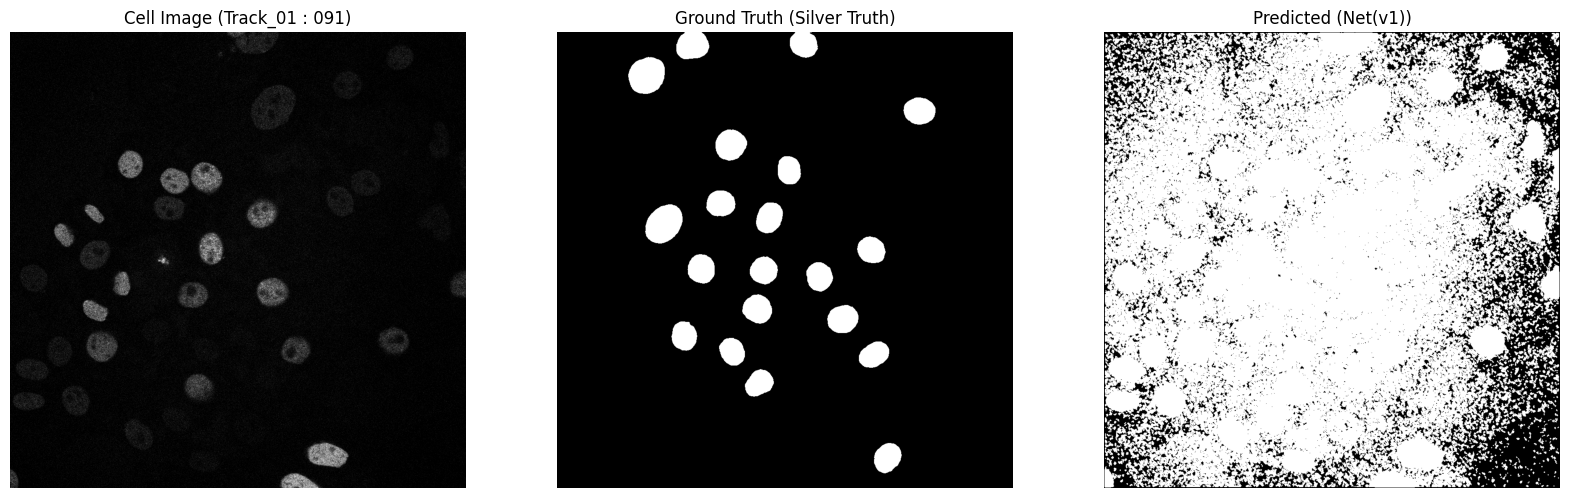

In [ ]:
display_all_viz(img_num, "01", "MLP")

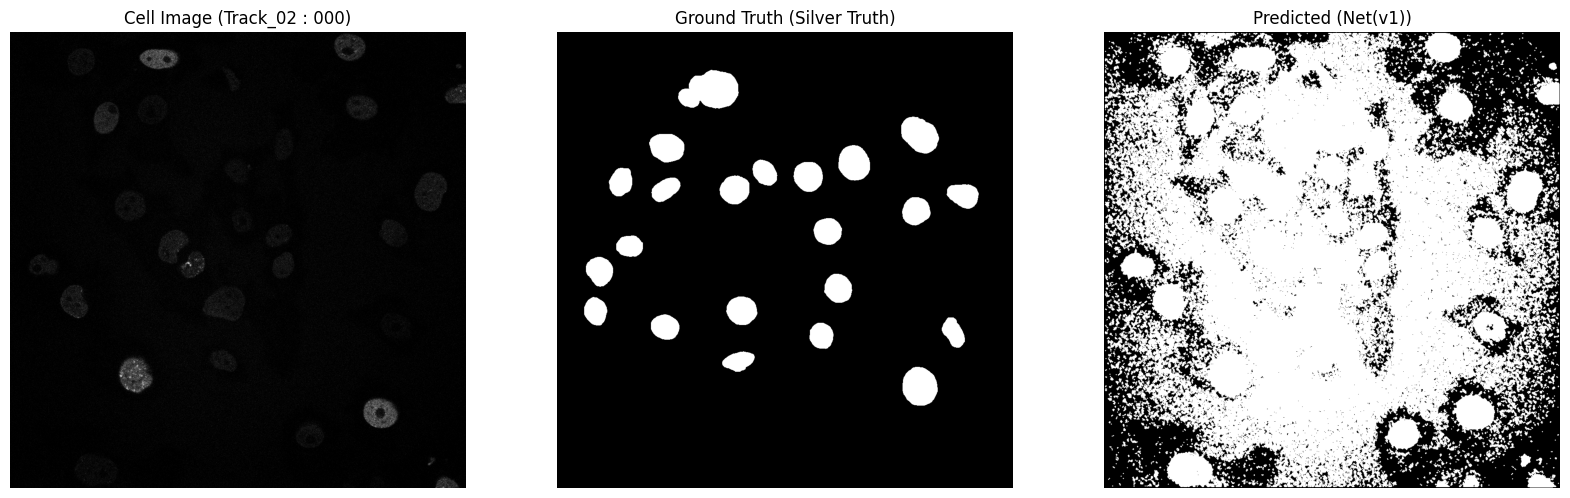

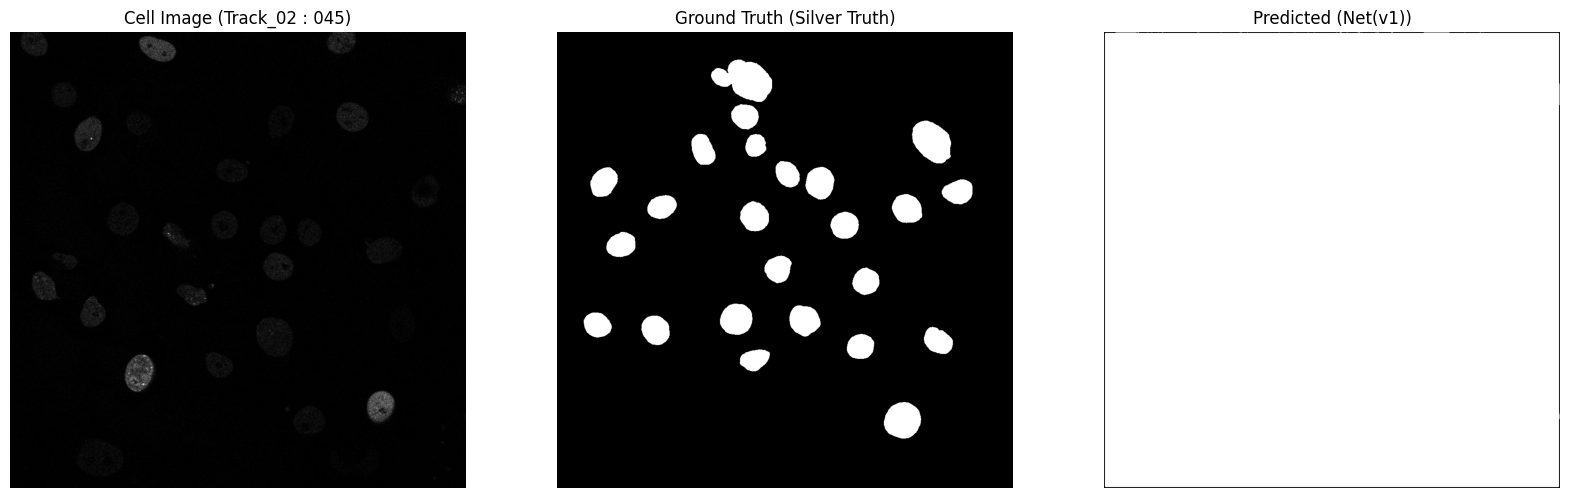

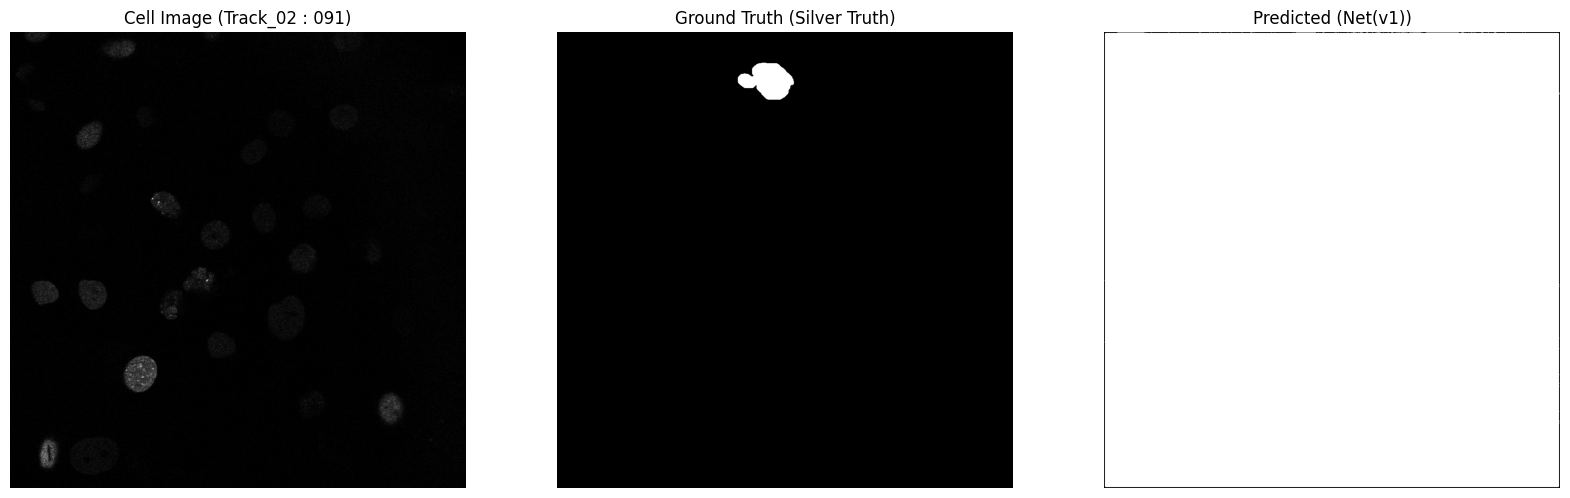

In [ ]:
display_all_viz(img_num, "02", "MLP")

In [ ]:

import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

In [ ]:
class CellDataset(Dataset):
    def __init__(self, dataset_dir, transforms=None):
        super(CellDataset, self).__init__()
        self.base_dir = dataset_dir
        self.transforms = transforms
        self.tracks = glob.glob(os.path.join(self.base_dir, "0[0-9]"))
        self.datadirs = []
        self.targetdirs = []
        for track in self.tracks:
            self.datadirs += sorted(glob.glob(os.path.join(track, "*.tif")))
            self.targetdirs += sorted(glob.glob(os.path.join(f"{track}_ST", "SEG", "*.tif")))
    def __getitem__(self, i):
        image = io.imread(self.datadirs[i])
        target = io.imread(self.targetdirs[i]) > 0
        if self.transforms:
            self.transforms(image)
        return image, target
    def __len__(self):
        return len(datadirs)

# Results

Use the snippets below to create a table of results.
When grading, I will look at this table to see if it is consistent with what the numbers should-be and if it is complete.



# Jaccard Indices for each Model (Including Indices for Preprocessed ones)

# **MLP MIoU Evaluation**

In [ ]:
!python MySEGMeasure.py {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_GT_SEG/ {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_MLP/




Mean Jaccard Index: 0.008235196848873184


In [ ]:
!python MySEGMeasure.py {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/02_GT_SEG/ {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/02_MLP/

Mean Jaccard Index: 0.003411729169051215


In [14]:
import pandas as pd
import numpy as np

# Define methods as columns -- customize if you add more
methods = ['Net (v1)']

# Define the variations heirarchically -- customize if you want to
# add other variations or other datasets from the contest site
datasets = {
    'Fluo-N2DH-GOWT1': {
        'ST': {'01', '02'},
        # 'GT': {'01', '02'}
    }
}

# Creating MultiIndex for rows
rows = []
for dataset, subsets in datasets.items():
    for subset, tracks in subsets.items():
        for track in tracks:
            rows.append((dataset, subset, track))

# Creating the DataFrame
multi_index = pd.MultiIndex.from_tuples(rows, names=['Dataset', 'Truth', 'Track'])
df = pd.DataFrame(index=multi_index, columns=methods).astype(float)


In [15]:
# Set the mIoU score for an experiment
df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'Net (v1)'] = 0.0082 # Whatever you get
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'Net (v1)'] = 0.0034
# Display the updated DataFrame
display(df)


Net (v1)
Dataset         Truth Track          
Fluo-N2DH-GOWT1 ST    02       0.0034
                      01       0.0082

# Submission

1.  Your solution should be contained within one notebook, with plenty of visualizations.
3.  Download your soution as a .ipynb file
4.  Use [my nbconvert notebook](https://colab.research.google.com/drive/13GvgiBl_jbGi3OSFbGAofmUBbh8yhOht#scrollTo=hiz8-EeUw95e) to create a PDF or docx to submit.